1.   In this kernel I will provide all the steps required for doing time series analysis using time series data and simple RNN, LSTM models and their hybrid.
2.   You can see the performance of simple RNN model, LSTM model, hybrid model and compare their performance




In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import SimpleRNN,Dropout

#Load the data file

In [4]:
df=pd.read_csv(('DOM_hourly.csv'))
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


#Date as Index

In [5]:
df=df.set_index('Datetime')
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


#Checking for missing values

In [6]:
df.isna().sum()

DOM_MW    1
dtype: int64

#Visualising the Data before Normalizing

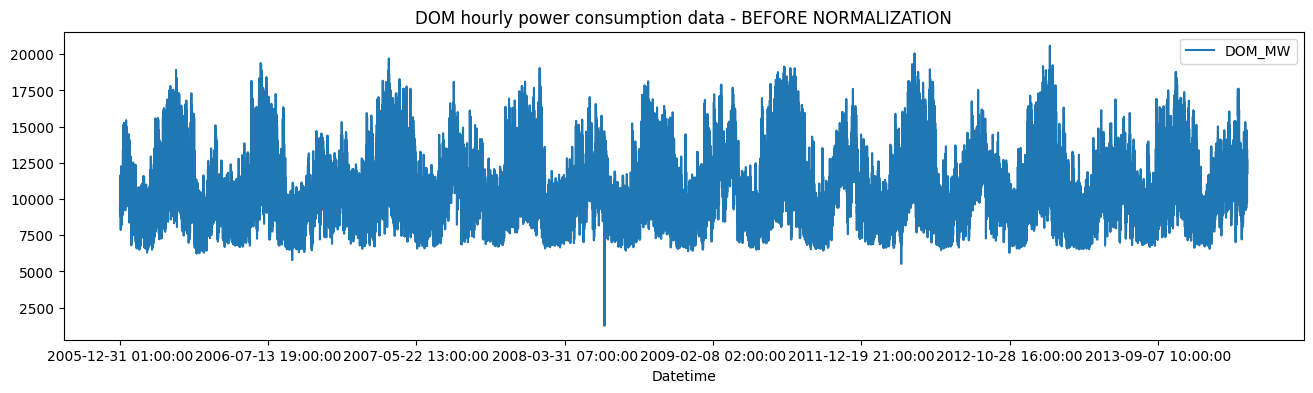

In [7]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

#Normalize the Data

In [ ]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(116189, 1)

#Visualising the Data after Normalizing

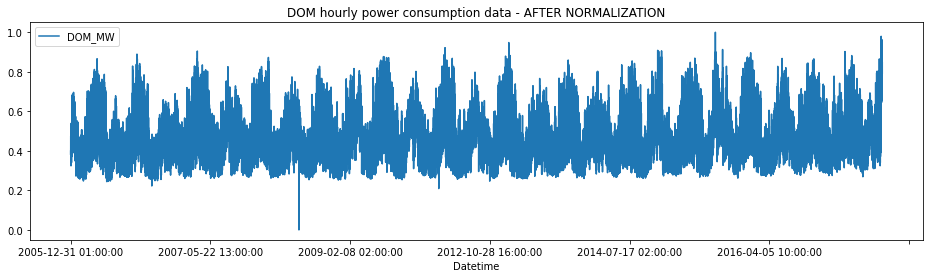

In [ ]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()


#Prepare Data for SimpleRNN and LSTM models

In [ ]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [ ]:
seq_len = 20 

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


#Build LSTM model

In [ ]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 40)            6720      
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4

In [ ]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 29s 227ms/step - loss: 0.0529
Epoch 2/10
110/110 [==============================] - 25s 228ms/step - loss: 0.0123
Epoch 3/10
110/110 [==============================] - 25s 228ms/step - loss: 0.0091
Epoch 4/10
110/110 [==============================] - 25s 231ms/step - loss: 0.0052
Epoch 5/10
110/110 [==============================] - 25s 228ms/step - loss: 0.0042
Epoch 6/10
110/110 [==============================] - 25s 227ms/step - loss: 0.0034
Epoch 7/10
110/110 [==============================] - 25s 228ms/step - loss: 0.0027
Epoch 8/10
110/110 [==============================] - 25s 230ms/step - loss: 0.0023
Epoch 9/10
110/110 [==============================] - 25s 229ms/step - loss: 0.0020
Epoch 10/10
110/110 [==============================] - 25s 227ms/step - loss: 0.0019


#Using r2 score to determine Accuracy

In [ ]:

lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.9498511123113029


#Compare the Actual and Predicted values

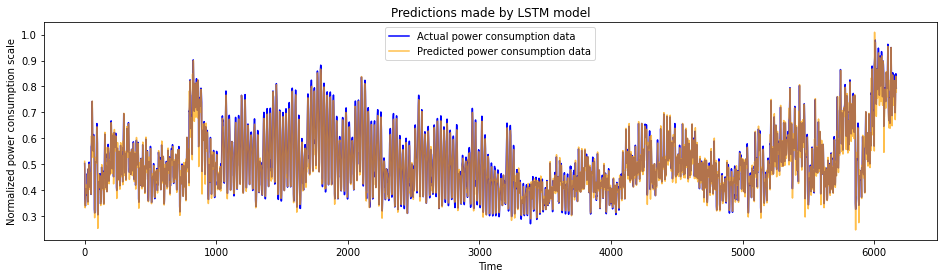

In [ ]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

#Build RNN model

In [ ]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20, 40)            1680      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 10s 79ms/step - loss: 0.1969
Epoch 2/10
110/110 [==============================] - 9s 80ms/step - loss: 0.0320
Epoch 3/10
110/110 [==============================] - 9s 80ms/step - loss: 0.0166
Epoch 4/10
110/110 [==============================] - 9s 80ms/step - loss: 0.0110
Epoch 5/10
110/110 [==============================] - 9s 80ms/step - loss: 0.0082
Epoch 6/10
110/110 [==============================] - 9s 80ms/step - loss: 0.0065
Epoch 7/10
110/110 [==============================] - 9s 79ms/step - loss: 0.0054
Epoch 8/10
110/110 [==============================] - 9s 79ms/step - loss: 0.0046
Epoch 9/10
110/110 [==============================] - 9s 78ms/step - loss: 0.0041
Epoch 10/10
110/110 [==============================] - 9s 78ms/step - loss: 0.0037


#Using r2 score to determine Accuracy

In [ ]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9397146441119624


#Compare the Actual and Predicted values

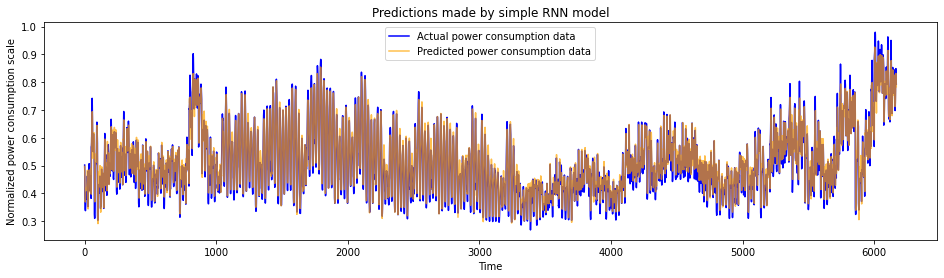

In [ ]:
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

#Compare the Actual and Predicted values from LSTM and simple RNN model

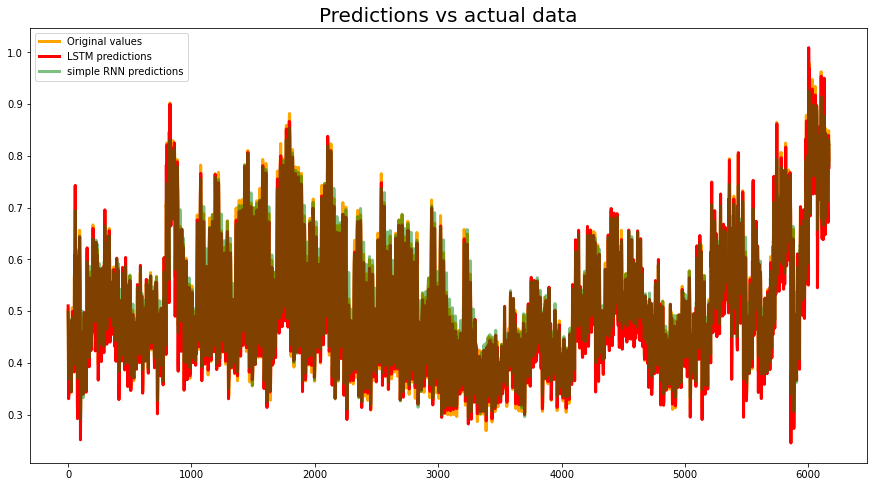

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="simple RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()

#Build a Hybrid model

In [ ]:
hybrid_model = Sequential()

hybrid_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
hybrid_model.add(Dropout(0.15))

hybrid_model.add(LSTM(40,activation="tanh",return_sequences=True))
hybrid_model.add(Dropout(0.15))

hybrid_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
hybrid_model.add(Dropout(0.15))

hybrid_model.add(Dense(1))

hybrid_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 20, 40)            1680      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_8 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [ ]:
hybrid_model.compile(optimizer="adam",loss="MSE")
hybrid_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 17s 133ms/step - loss: 0.0860
Epoch 2/10
110/110 [==============================] - 15s 133ms/step - loss: 0.0088
Epoch 3/10
110/110 [==============================] - 15s 133ms/step - loss: 0.0056
Epoch 4/10
110/110 [==============================] - 15s 136ms/step - loss: 0.0044
Epoch 5/10
110/110 [==============================] - 15s 132ms/step - loss: 0.0037
Epoch 6/10
110/110 [==============================] - 15s 132ms/step - loss: 0.0032
Epoch 7/10
110/110 [==============================] - 15s 132ms/step - loss: 0.0029
Epoch 8/10
110/110 [==============================] - 15s 132ms/step - loss: 0.0025
Epoch 9/10
110/110 [==============================] - 15s 132ms/step - loss: 0.0023
Epoch 10/10
110/110 [==============================] - 15s 133ms/step - loss: 0.0021


#Using r2 score to determine Accuracy

In [ ]:
hybrid_predictions = hybrid_model.predict(X_test)

hybrid_score = r2_score(y_test,hybrid_predictions)
print("R2 Score of RNN-LSTM model = ",hybrid_score)

R2 Score of RNN-LSTM model =  0.9310016256263853


#Compare the Actual and Predicted values

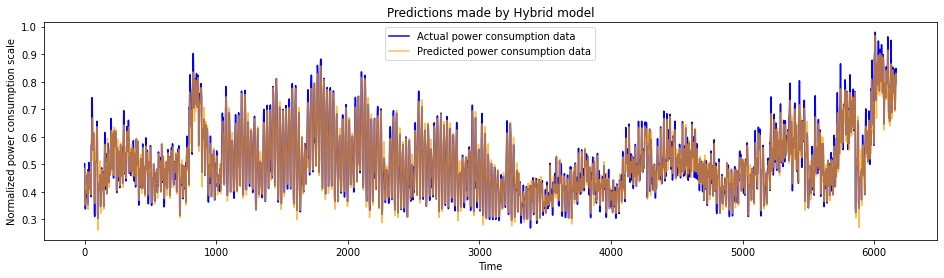

In [ ]:
plot_predictions(y_test, hybrid_predictions, "Predictions made by Hybrid model")